# LLM Agents for Clinical Trial Management

In this notebook, we develop an agent-based Large Language Model (LLM) application to automate the evaluation of patients for potential clinical trials. By leveraging documents related to patients' medical histories, clinical policies, and trial inclusion criteria, such an agentic system can significantly enhance the quality of evaluations and reduce the time required.

We use limited demo databases and simple agentic tools and pipelines to demonstrate the capabilities of such LLM systems. For real-world applications, more comprehensive medical databases, in collaboration with clinical specialists, will be necessary. Additionally, more advanced tools (e.g., advanced Retrieval-Augmented Generation (RAG) methods) must be incorporated for real applications.

**Objective:** Automate clinical trial data management, analysis, compliance checks, and reporting.

## Key Components of This Design: 
1. Patient Data Collection: Gather comprehensive medical histories and relevant patient information.
2. Patient Data Analysis: Analyze patient data to identify key health indicators and relevant medical conditions.
3. Clinical Compliance Verification: Ensure patient data complies with clinical policies and trial eligibility criteria.
4. Trial Matching: Match patients with suitable clinical trials based on their medical profiles.
5. Human-in-the-Loop Interventions: Allow clinical experts to review and modify intermediate and final outcomes.

## Technologies and Tools Used:
- Local Models: Embedding of policies and trial information.
- Local Vector Stores: Information retrieval using metadata.
- Information Retrieval: Using metadata to find relevant documents.
- Chains of LLM Calls: Sequential LLM calls to perform complex tasks.
- Python Shell: LLM integration for performing numerical calculations.
- Agentic Graph: Deploying a workflow for evaluating patients and trials.
- Human-in-the-Loop: Clinical experts can intervene and modify the evaluation process and results.

In [1]:
%load_ext autoreload
%autoreload 2
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

# Loading the requied environment variables
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Clinical Trial Management"

# Parameters

In [111]:
from langchain_openai import ChatOpenAI


policy_vstore_created = False
trials_vstore_created = False
trials_db_downloaded = False
chromadb_path = "../../chroma_db"
policy_collection = "policy-chroma"
trial_collection = "trial-chroma"

modelID = "gpt-3.5-turbo"
n_retrieved_policies = 5 # Number of most relevant policies to retrieve per patient
# n_retries = 6
n_retrieved_trials = 6



model = ChatOpenAI(temperature = 0.0, model=modelID)

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pprint
# A function for printing nicely
def nprint(text, indent=2):
    pp = pprint.PrettyPrinter(indent=indent)
    pp.pprint(text)

# Creating the demo datasets

## Patients database

We create a sample dataset of patients with their medical history, previous trials, and other relevant information.   
We use random names, diseases, and past or ongoing trials.  
This is a demo dataset limited information. However, for real cases, a more complit medical history of patients will be used.

In [33]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import json
import random

# Generate the sample data again for display
columns = ["patient_id", "name", "age", "medical_history", "previous_trials", "trial_status", "trial_completion_date"]
data = []

# Given names and surnames
names = ["John", "Jane", "Alice", "Michael", "Emily", "Daniel", "Sophia", "James", "Emma", "Oliver"]
surnames = ["Doe", "Smith", "Johnson", "Brown", "Davis", "Garcia", "Martinez", "Anderson", "Thomas", "Wilson"]

# Generate all possible unique combinations of names and surnames
combinations = [(name, surname) for name in names for surname in surnames]

# Shuffle the combinations to ensure randomness
random.shuffle(combinations)

# Select the first 100 unique combinations
unique_names = combinations[:100]

# Generate the full names
full_names = [f"{name} {surname}" for name, surname in unique_names]

with open('../../source_data/diseases_list.json', 'r') as file:
        trial_diseases =  json.load(file)

list_trial_diseases = list({disease for diseases in trial_diseases.values() for disease in diseases})

other_medical_conditions = ["Hypertension", "Diabetes", "Asthma", "Heart Disease", "Arthritis",
                      "Chronic Pain", "Anxiety", "Depression", "Obesity"]

all_conditions = list(set(list_trial_diseases + other_medical_conditions))

trial_statuses = ["Completed", "Ongoing", "Withdrawn"]

def random_date(start, end):
    return start + timedelta(days=random.randint(0, int((end - start).days)))

# start_date must be 2 years before now
start_date = datetime.now() - timedelta(days=365 * 2)
# start_date = datetime(2020, 1, 1)

# end_date must be a month before now
end_date = datetime.now() - timedelta(days=10)
# end_date = datetime(2023, 1, 1)

for i in range(1, 101):
    name = random.choice(full_names)
    age = random.randint(20, 80)
    medical_history = random.choice(all_conditions)
    
    if random.choice([True, False]):
        previous_trials = f"NCT0{random.randint(1000000, 9999999)}"
        trial_status = random.choice(trial_statuses)
        trial_completion_date = random_date(start_date, end_date).strftime('%Y-%m-%d')
    else:
        previous_trials = ""
        trial_status = ""
        trial_completion_date = ""
    if trial_status == "Ongoing":
        trial_completion_date = ""

    data.append((i, name, age, medical_history, previous_trials, trial_status, trial_completion_date))

df = pd.DataFrame(data, columns=columns)
# save df to csv
df.to_csv("patients.csv", index=False)
df.head(20)

,patient_id,name,age,medical_history,previous_trials,trial_status,trial_completion_date
0,1,Jane Anderson,48,Obesity,,,
1,2,Alice Brown,40,Diabetes,NCT05724456,Withdrawn,2023-11-18
2,3,Alice Wilson,51,peritoneal cancer,NCT07030148,Withdrawn,2023-11-30
3,4,James Martinez,72,gastric cancer,NCT06745637,Completed,2023-08-09
4,5,Michael Wilson,66,pancreatic cancer,NCT06410934,Completed,2022-07-26
5,6,Jane Doe,72,myeloma,,,
6,7,Emma Brown,56,prostate cancer,,,
7,8,Michael Thomas,28,lung cancer,NCT04356469,Ongoing,
8,9,Oliver Wilson,33,myelomonocytic leukemia,,,
9,10,Emma Wilson,79,leiomyosarcoma,NCT06400191,Completed,2023-06-08


Creating a local SQLite database for patients

In [68]:
import os
import sqlite3
import pandas as pd

overwrite = True

database_file = 'patients_database.db'
df = pd.read_csv('patients.csv')
if overwrite or not os.path.exists(database_file):
    if os.path.exists(database_file):
        os.remove(database_file)
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS patients (
        patient_id INTEGER PRIMARY KEY,
        name TEXT,
        age INTEGER,
        medical_history TEXT,
        previous_trials TEXT,
        trial_status TEXT,
        trial_completion_date TEXT
    )
    ''')

    # Insert DataFrame into SQLite table
    df.to_sql('patients', conn, if_exists='append', index=False)

    # Commit and close the connection
    conn.commit()
else:
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()

query = 'SELECT * FROM patients'

# Execute the query and fetch all results
cursor.execute(query)
rows = cursor.fetchall()

# Optionally, you can get the column names
column_names = [description[0] for description in cursor.description]

# Convert the results to a Pandas DataFrame for better readability
df = pd.DataFrame(rows, columns=column_names)
print(len(df))

# Display the DataFrame
conn.close()

db = database_file
df.head(10)

100


,patient_id,name,age,medical_history,previous_trials,trial_status,trial_completion_date
0,1,James Anderson,75,Heart Disease,None,None,None
1,2,Emily Martinez,73,esophageal cancer,None,None,None
2,3,Alice Thomas,24,prostate cancer,None,None,None
3,4,Alice Garcia,39,solid tumors,None,None,None
4,5,John Davis,40,Hypertension,NCT09100764,Withdrawn,2023-10-24
5,6,John Garcia,45,Asthma,NCT04864147,Withdrawn,2022-08-12
6,7,Michael Smith,64,Obesity,NCT08217147,Withdrawn,2024-02-18
7,8,Oliver Thomas,25,solid tumors,NCT06705148,Completed,2023-06-23
8,9,Emily Martinez,27,ovarian cancer,None,None,None
9,10,Emma Brown,26,mesothelioma,None,None,None


In [70]:
df[df['medical_history'].str.contains('Obes')]

,patient_id,name,age,medical_history,previous_trials,trial_status,trial_completion_date
6,7,Michael Smith,64,Obesity,NCT08217147,Withdrawn,2024-02-18
14,15,Emma Martinez,35,Obesity,None,None,None
35,36,Michael Brown,76,Obesity,NCT07416735,Completed,2023-11-18


## Clinical Trials database

We download a sample clinical trials database from a [publicly available source]('https://raw.githubusercontent.com/futianfan/clinical-trial-outcome-prediction/main/data/raw_data.csv').   
Details are provided in the [helper function](../../src/helper_functions.py)

In [7]:
import sys
module_dir = os.path.abspath('../../src')  # Gets the absolute path to the src directory
sys.path.append(module_dir)
from helper_functions import dataset_create_trials

overwrite = False
if trials_db_downloaded and not overwrite:
    print(f'Trials database already downloaded and stored in {trials_path}')
    df_trials = pd.read_csv(trials_path)
else:
    df_trials, trials_path = dataset_create_trials(status='recruiting')
    trials_db_downloaded = True

# print the ctriteria column value froom 4 random rows of the dataferam. use a for loop
df_samples = df_trials.sample(4).reset_index(drop=True)
for i in range(4):
    print(f'---- Sample {i+1} ----')
    print(df_samples.iloc[i]['criteria'])


Only trials with status recruiting are selected.
The database for trials is saved to ../../data/trials_data.csv 
 It has 30 rows.
---- Sample 1 ----

        Inclusion Criteria:

          -  Newly diagnosed adult B-precursor Ph+ ALL patients.

          -  Age greater or equal to18 years,

          -  Signed written informed consent according to ICH/EU/GCP and national local laws.

          -  ECOG Performance Status 0 or 1 and/or WHO performance status less or equal to 2.

          -  Renal and hepatic function as defined below:

               -  AST (GOT), ALT (GPT), and AP <2 x upper limit of normal (ULN).

               -  Total bilirubin <1.5 x ULN.

               -  Creatinine clearance equal or greater than 50 mL/min.

          -  Pancreatic function as defined below:

               -  Serum amylase less or equal to 1.5 x ULN

               -  Serum lipase less or equal to1.5 x ULN.

          -  Normal cardiac function.

          -  Negative HIV test, negative HBV DN

# Creating Vectore Stores

## Vstore for policy database

To create a vector store for the policy database, we will use perform local embedding via NomicEmbeddings.   
Also, to treat each policy separately, we split the policies main document into per policy chunks.   
Note that this is a problem specific strategy, and may not be appropriate for all RAG applications.

In [80]:
import re

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_core.documents import Document
import chromadb

# vstore_delete = False
vstore_load = True
markdown_path = "../../source_data/instut_trials_policy.md"

with open(markdown_path, "r") as f:
    policy_text = f.read()


doc_splits = [
    Document(page_content= txt, metadata={"source": markdown_path}) for txt in re.split(r"(?=\n###)", policy_text)
    ]

# the title of markdown is not required in the split
doc_splits = doc_splits[1:]    

print(len(doc_splits))
doc_splits

persistent_client = chromadb.PersistentClient(path = chromadb_path)

if vstore_load == False:
    vectorstore.delete_collection()


# if chromadb_path exists
if os.path.exists(chromadb_path) and vstore_load:
    vectorstore = Chroma(
        client=persistent_client,
        collection_name=policy_collection,
        embedding_function=NomicEmbeddings(model="nomic-embed-text-v1.5",
                                inference_mode='local'),
    )
    print('Vectore store loaded from existing chromadb')
    # vectorstore._collection.count()
else:
    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        client=persistent_client,
        collection_name=policy_collection,
        # persist_directory=chromadb_path,
        embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                                inference_mode='local'),
    )
    print('Vectore store created and stored in persistent chromadb client')
print(vectorstore._collection.count())
doc_splits


12
Vectore store loaded from existing chromadb
12


[Document(page_content='\n#### 1. **General Eligibility Criteria**\n   - **Age Restrictions**: Patients must be between 18 and 75 years old.\n   - **Gender**: No restrictions unless specified by the trial protocol.\n   - **Informed Consent**: All patients must provide informed consent prior to participation.\n   - **Residency**: Patients must be residents of the country where the trial is conducted.\n   - **Health Insurance**: Patients must have valid health insurance coverage.\n', metadata={'source': '../../source_data/instut_trials_policy.md'}),
 Document(page_content='\n#### 2. **Medical History Restrictions**\n   - **Severe Heart Disease** (e.g., recent myocardial infarction, heart failure)\n   - **Uncontrolled Diabetes Mellitus**     \n   - **Recent Surgeries**: Patients who have undergone major surgery within the current year are not eligible.   \n   - **Infectious Diseases**: Patients with active tuberculosis, hepatitis B or C, or HIV are excluded unless the trial is specificall

## Vstore for trials

For simplicy, we just work on 3 main categories of cancer, lukemia, and mental health problems.   
This selection gives us a managable set of trials as a demo application.   
However, for a more proper application, categories can be extended with the help of domain specialists.

The vectore store is created using chromadb and as a persistent client.

In [9]:
from helper_functions import disease_map

vstore_delete = False

trial_docs = []
for i, row in df_trials.iterrows():
    disease = disease_map(row['diseases'])
    if disease == 'other_conditions':
        continue
    doc = Document(
        page_content=row['criteria'],
        metadata={
            "nctid": row['nctid'],
            "status": row['status'],
            # "why_stop": row['why_stop'],
            # "label": row['label'],
            # "phase": row['phase'],
            "diseases": str(row['diseases']),
            "disease_category": disease[0],
            "drugs": row['drugs'],            
        }
    )
    trial_docs.append(doc)
# trial_docs

print(trial_docs[0].metadata)

list_remove = set()
for i, doc in enumerate(trial_docs):
    if len(doc.page_content)>10000:
        list_remove.add(i)
        # print(doc.metadata)
    if doc.metadata['disease_category'] == 'other_conditions':
        list_remove.add(i)
        # print(doc.metadata)
# remove list_remove indexes from trial_docs
trial_docs = [doc for i, doc in enumerate(trial_docs) if i not in list_remove]

# print(len(trial_docs[11].page_content))
# trial_docs.pop(11)

persistent_client = chromadb.PersistentClient(path = chromadb_path)

if vstore_delete == True:
    vectorstore_trials.delete_collection()
    trials_vstore_created = False
    vstore_delete = False
    print("vstore deleted")

vectorstore_trials = Chroma(
    client=persistent_client,
    collection_name=trial_collection,
    embedding_function=NomicEmbeddings(model="nomic-embed-text-v1.5",
                            inference_mode='local'),
)
if vectorstore_trials._collection.count() == 0:
    vectorstore_trials = Chroma.from_documents(
        documents=trial_docs,
        client=persistent_client,
        collection_name=trial_collection,
        # persist_directory=chromadb_path,
        embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                                inference_mode='local'),
    )
    trials_vstore_created = True
    print("Vectorstore is created now")
else:
    print("Loading the vectorstore from persistent client")

print(vectorstore_trials._collection.count())
trial_docs


{'nctid': 'NCT00715611', 'status': 'recruiting', 'diseases': "['mesothelioma']", 'disease_category': 'cancer', 'drugs': "['pemetrexed and cisplatin or carboplatin']"}
Loading the vectorstore from persistent client
18


[Document(page_content='\n        Inclusion Criteria:\r\n\r\n          -  Provide written informed consent to participate on the study\r\n\r\n          -  Patients must have a pathologically confirmed diagnosis either at MSKCC or at the\r\n             participating site of stage I-III malignant pleural mesothelioma\r\n\r\n          -  Epithelioid or biphasic histology subtype (Note: patients with biphasic histology can\r\n             have < 10% sarcomatoid)\r\n\r\n          -  No evidence of metastatic disease.\r\n\r\n          -  Patient age ≥ 18 years but ≤ 80 years at the time of consent.\r\n\r\n          -  Karnofsky performance status ≥ 80%\r\n\r\n          -  Pulmonary Function Tests:\r\n\r\n               1. For all patients: DLCO > 40% predicted (corrected for Hgb)\r\n\r\n               2. For patients enrolled post-P/D, only: FEV1 >/= 35% (corrected for Hgb) (Note:\r\n                  patients enrolled prior to P/D will have PFTs repeated pre-IMRT. If this criteria\r\n     

# Tools:
Here we define some tools that the agent needs to use for evaluation of the patient, general policies, and clinic trials.

### Patient Data Extractor

In [66]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

def get_patient_data(patient_id: int) -> dict:
    """Fetch all fields for the patient based on the given patient_id as an integer.

    Returns:
        A dictionary containing the patient's medical history.        
    """    

    conn = sqlite3.connect(db)
    cursor = conn.cursor()    
    query = 'SELECT * FROM patients WHERE patient_id=?'
    cursor.execute(query, (patient_id,))
    patient_data = cursor.fetchone()
    # rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    conn.close()
    if patient_data is None:
        return None
    else:    
        results = dict(zip(column_names, patient_data))    
    return results

# Also possible to add a new patient
def add_patient_data(patient_data: dict):    
    """Adds a new patient to the SQLite database."""
    
    name = patient_data['name']
    age = patient_data['age']
    medical_history = patient_data['medical_history']
    previous_trials = patient_data['previous_trials']
    trial_status = patient_data['trial_status']
    last_trial_dates = patient_data['last_trial_dates']

    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    
    # Insert the new patient data into the database
    cursor.execute('''
    INSERT INTO patients (name, age, medical_history, previous_trials, trial_status, last_trial_dates)
    VALUES (?, ?, ?, ?, ?, ?)
    ''', (name, age, medical_history, previous_trials, trial_status, last_trial_dates))
    
    conn.commit()
    conn.close()

In [82]:
sample_patient_id = 1
patient_data = get_patient_data(sample_patient_id)
patient_data

{'patient_id': 1,
 'name': 'James Anderson',
 'age': 75,
 'medical_history': 'Heart Disease',
 'previous_trials': None,
 'trial_status': None,
 'trial_completion_date': None}

### Profile Maker

In [85]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate

parser = StrOutputParser()
prompt_profile = PromptTemplate(
    template="""
    You are the Clinical Research Coordinator in the screening phase of a clinical trial. 
    Use the following patient data to write the patient profile for the screening phase.
    The patient profile is a summary of the patient's information in continuous text form.    
    If they had no previous trial participation, exclude trial status and trial completion date.\n
    Do not ignore any available information.\n 
    Also suggest medical trials that can be related to patient's disease history.\n    
    Write the patient profile in 3 to 4 short sentences.\n\n
    {patient_data}""",
    input_variables=["patient_data"],
)
# In a separate section of the profile, also suggest medical trial categories related to patient's disease history.\n    
# model = ChatOpenAI(temperature = 0.0, model=modelID)

chain_profile = prompt_profile | model | parser
# to preserve the patient's private information

In [103]:
# to preserve the patient's private information
if patient_data.get('name'):
    del patient_data['patient_id']
    del patient_data['name']

patient_profile = chain_profile.invoke({'patient_data': patient_data})
nprint(patient_profile) # patient_profile

('Patient is a 75-year-old individual with a medical history of Heart Disease. '
 'They have not participated in any previous clinical trials. Given their '
 'history of Heart Disease, potential medical trials that could be related to '
 'their condition include those focusing on cardiovascular health and '
 'treatment options for heart-related issues.')


### Policy Retriever


In [112]:
retriever_policy = vectorstore.as_retriever(search_kwargs={"k": n_retrieved_policies})

# sample policy retrieval
docs_retrieved = retriever_policy.get_relevant_documents(patient_profile)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content
docs_retrieved

5


[Document(page_content='\n#### 2. **Medical History Restrictions**\n   - **Severe Heart Disease** (e.g., recent myocardial infarction, heart failure)\n   - **Uncontrolled Diabetes Mellitus**     \n   - **Recent Surgeries**: Patients who have undergone major surgery within the current year are not eligible.   \n   - **Infectious Diseases**: Patients with active tuberculosis, hepatitis B or C, or HIV are excluded unless the trial is specifically designed for these conditions.\n', metadata={'source': '../../source_data/instut_trials_policy.md'}),
 Document(page_content='\n#### 3. **Previous Trial Participation**   \n   - **Trial Frequency**: Patients should not have participated in more than two clinical trials in the past year excluding this trial to prevent overexposure to experimental treatments.\n   - **Active Trials**: Patients currently enrolled in another active trial are not eligible until they have completed or withdrawn from the ongoing trial.\n   - **Recent Trials**: Patients c

### Policies to Questions

In [15]:
# Policies --> questions
from langchain_core.pydantic_v1 import BaseModel, Field

prompt_rps = PromptTemplate(
    template=""" You are a Principal Investigator (PI) for clinical trials. 
        The following document contains a policy document about participation in clinial trials:
        \n\n{policy}\n\b

        Your task is to rephrase each single policy from the document above into a single yes/no question. 
        Form each question so that a yes answer indicates the patient's ineligibility.
        Do not create more questions than given number of policies.

        Example: Patients who have had accidents in the past 10 months are not eligible
        rephrased: Did patient have an accident in the past 10 months?

        Example: Patients with active tuberculosis, hepatitis B or C, or HIV are excluded unless the trial is specifically designed for these conditions.
        rephrased: Did patient have active tuberculosis, hepatitis B or C, or HIV?
        """,
    input_variables=["policy"],
)

class policy_relevance(BaseModel):
    "policy relevance score"

    relevant: str = Field(description="is policy relevant? 'yes' or 'no'.")
    reason: str

parser = StrOutputParser()

policy_rps_chain = prompt_rps | model | parser


In [16]:

policy = docs_retrieved[0].page_content
policy_qs = policy_rps_chain.invoke({"policy": policy})
nprint(policy_qs)

('1. Is the patient under 18 or over 75 years old?\n'
 "2. Is the patient's gender restricted by the trial protocol?\n"
 '3. Has the patient not provided informed consent?\n'
 '4. Is the patient not a resident of the country where the trial is '
 'conducted?\n'
 '5. Does the patient not have valid health insurance coverage?')


### Policy Evaluator with Python Tools

In [17]:
from langchain_core.tools import StructuredTool
from datetime import date, datetime
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import create_react_agent


def policy_tools(policy_qs: str, patient_profile: str):
    system_message = """
    You are a Principal Investigator (PI) for evaluating patients for clinical trials.
    You are asked to compare the patient profile document to the institution policy questions.
    You must determine if the patient is eligible based on the following documnents.

    \n #### Here is the patient profile document: \n {patient_profile}\n\n

    If the answer to any policy question is yes, then the patient is not eligible.\n
    If the answer to the question is not provided in the patient profile, answer 'no'.\n

    Give a binary 'yes' or 'no' score in the response to indicate whether the patient is eligible according to the given policy ONLY.
    If the patient is not eligible then also include the reason in your response.

    You have access to the following tools:
    {tool_names}
    """

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_message),
            ("human", "{input}"),
            # Placeholders fill up a **list** of messages
            ("placeholder", "{agent_scratchpad}"),
        ]
    )

    class CalculatorInput(BaseModel):
        num1: float = Field(description="first number")
        num2: float = Field(description="second number")

    def multiply(num1: float, num2: float) -> float:
        "multiplies two input numbers together, num1 and num2"
        return (num1 * num2)

    multiply_tool = StructuredTool.from_function(
        func=multiply,
        name="multiply",
        description="multiply numbers",
        args_schema=CalculatorInput,
        # return_direct=True,    
    )

    @tool("date_today-tool")
    def date_today() -> datetime.date:
        "returns today date"
        return datetime.today().date()    

    def date_difference(date1: date, date2: date) -> int:
        "The number of months date1 is before date2"
        # "How many months before date2 is date1?"
        month_difference = (date2.year - date1.year) * 12 + date2.month - date1.month
        return f'{month_difference} months'

    class dates(BaseModel):
        date1: date = Field(description="first date")
        date2: date = Field(description="second date")

    date_difference_tool = StructuredTool.from_function(
        func=date_difference,
        name="date_difference",
        description="The number of months first date is before second date",
        args_schema=dates,
        # return_direct=True,    
    )

    class date_class(BaseModel):
        date: str = Field(description="A date string in the format YYYY-MM-DD")    

    @tool("date_convert-tool", args_schema=date_class)
    def date_convert(date: str) -> date:
        "Converts a date string to a date object"
        # "How many months before date2 is date1?"
        date = datetime.strptime(date, "%Y-%m-%d").date()
        return date

    @tool("date_split-tool", args_schema=date_class)
    def date_split(date: str) -> date:
        "Extracts the year and month from a date string"
        # "How many months before date2 is date1?"
        date = datetime.strptime(date, "%Y-%m-%d").date()
        year = date.year
        month = date.month
        return f'year: {year}, month: {month}'

    @tool("number_comparison-tool", args_schema=CalculatorInput)
    def number_compare(num1: float, num2: float) -> bool:
        "Determines if first number is less than the second number"
        # "How many months before date2 is date1?"
        num1_less_num1 = num1 < num2
        return num1_less_num1

    tools = [multiply_tool, date_today, date_difference_tool, date_split, number_compare]

    tool_names=", ".join([tool.name for tool in tools])
    prompt = prompt.partial(tool_names=tool_names)
    prompt = prompt.partial(patient_profile=patient_profile)

    model_agent = ChatOpenAI(temperature=0, model="gpt-4o")
    react_agent = create_react_agent(model_agent, tools, prompt, debug=False)

    message = f""" Here are the policy questions: \n{policy_qs}"""
    messages = react_agent.invoke({"messages": [("human", message)]})
    result = messages["messages"][-1].content    
    return result

In [18]:
# sample policy evaluation
import langchain
langchain.debug = True
policy = docs_retrieved[0].page_content
# nprint(policy)
result = policy_tools(policy, patient_profile)
nprint(result)
langchain.debug = False

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "messages": [
    [
      "human",
      " Here are the policy questions: \n\n#### 1. **General Eligibility Criteria**\n   - **Age Restrictions**: Patients must be between 18 and 75 years old.\n   - **Gender**: No restrictions unless specified by the trial protocol.\n   - **Informed Consent**: All patients must provide informed consent prior to participation.\n   - **Residency**: Patients must be residents of the country where the trial is conducted.\n   - **Health Insurance**: Patients must have valid health insurance coverage.\n"
    ]
  ]
}
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
{
  "messages": [
    [
      "human",
      " Here are the policy questions: \n\n#### 1. **General Eligibility Criteria**\n   - **Age Restrictions**: Patients must be between 18 and 75 years old.\n   - **Gender**: No restrictions unless specified by the trial protocol.\n   - **Informed Consent**: All

[tool/start] [chain:LangGraph > chain:tools > tool:date_split-tool] Entering Tool run with input:
"{'date': '2023-10-01'}"
[tool/end] [chain:LangGraph > chain:tools > tool:date_split-tool] s] Exiting Tool run with output:
"year: 2023, month: 10"
[chain/start] [chain:LangGraph > chain:tools > chain:ChannelWrite<tools,messages>] Entering Chain run with input:
[inputs]
[chain/end] [chain:LangGraph > chain:tools > chain:ChannelWrite<tools,messages>] s] Exiting Chain run with output:
[outputs]
[chain/end] [chain:LangGraph > chain:tools] s] Exiting Chain run with output:
[outputs]
[chain/start] [chain:LangGraph > chain:agent] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:agent > chain:call_model] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:agent > chain:call_model > chain:RunnableSequence] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:agent > chain:call_model > chain:RunnableSequence > prompt

### Trials Retriever 

We use SelfQueryRetriever module that also uses metadata information. This retrival can quickly find relevant trials based on metadata such as disease category, drug names, etc.   
The value of such retrival becomes important for real applications, where patient profiles contain more comphrehensive medical histories.

In [19]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="disease_category",
        description="Defines the disease group of patients related to this trial. One of ['cancer', 'leukemia', 'mental_health']",
        # description="The trial is for patients when their disease is related to this category. One of ['cancer', 'leukemia', 'mental_health']",
        type="string",
    ),
    AttributeInfo(
        name="drugs",
        description="List of drug names used in the trial",
        type="str",
    ),    
]

document_content_description = "The list of patient conditions to include or exclude them from the trial"
retriever_trial_sq = SelfQueryRetriever.from_llm(
    model,
    vectorstore_trials,
    # vectorstore_trials_mpnet,
    document_content_description,
    metadata_field_info
    # enable_limit=True
)

In [20]:
# sample trial retrieval
question = f"""
Which trials are relevant to the patient with the following medical history?\n
patient_profile: {patient_profile}
"""        
docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
print(docs_retrieved[0].metadata)
print(docs_retrieved[0].page_content)

{'disease_category': 'leukemia', 'diseases': "['relapsed or refractory acute myeloid leukemia (aml)', 'untreated aml', 'other idh1-mutated positive hematologic malignancies', 'myelodysplastic syndromes']", 'drugs': "['ag-120']", 'nctid': 'NCT02074839', 'status': 'recruiting'}

        Key Inclusion Criteria:

          -  Subject must be ≥18 years of age.

          -  Subjects must have documented IDH1 R132 gene-mutated advanced hematologic malignancy
             based on local or central evaluation.

          -  Subjects must be amenable to serial bone marrow biopsies, peripheral blood sampling,
             and urine sampling during the study.

          -  Subjects must have ECOG PS of 0 to 2.

          -  Platelet count ≥20,000/µL (Transfusions to achieve this level are allowed).

          -  Subjects must have adequate hepatic function as evidenced by: Aspartate
             aminotransferase (AST), alanine aminotransferase (ALT), and alkaline phosphatase (ALP)
             ≤3

### Trial Grader

In [21]:
class grade(BaseModel):
        """The result of the trial's relevance check as relevance score and explanation."""

        relevance_score: str        
        explanation: str = Field(description="Reasons to the given relevance score.")        
        further_information: str

prompt_grader = PromptTemplate(
        template=""" 
        You are a Principal Investigator (PI) for evaluating patients for clinical trials.\n
        Your task is to evaluate the relevance of a clinical trial to the given patient's medical profile. \n
        
        
        The clinical trial is related to these diseases: {trial_diseases} \n
        Here are the inclusion and exclusion criteria of the trial: \n\n {document} \n\n
        
        ===============                
        Use the following steps to determine relevance and provide the necessary fields in your response: \n
        1- If the patient's profile meets any exclusion criteria, then the trial is not relevant --> relevance_score = 'No'. \n
        2- If the patient has or had the trial's inclusion diseases, then it is relevant --> relevance_score = 'Yes'.\n        
        3- If the patient did not have the trial's inclusion diseases, then it is not relevant --> relevance_score = 'No'.\n
                       
        Example 1: 
The patient has Arthritis and the trial is related to pancreatic cancer. --> relevance_score = 'No' \n
        
        Example 2: 
The patient has pancreatic cancer and the trial is also related to carcinoma pancreatic cancer. --> relevance_score = 'Yes' \n

        Example 3: 
The patient has pancreatic cancer and the trial is related to breast cancer or ovarian cancer. --> relevance_score = 'No'. \n 

        Bring your justification in the explanation. \n

        Mention further information that is needed from the patient's medical history related to the trial's criteria \n

        ===============
        Here is the patient's medical profile: {patient_profile} \n\n
        """,
        input_variables=["document", "patient_profile", "trial_diseases"],
    )

llm_with_tool = model.with_structured_output(grade)
retrieval_grader = prompt_grader | llm_with_tool

In [22]:
doc = docs_retrieved[0]
doc_txt = doc.page_content
trial_diseases = doc.metadata.get("diseases")
trial_score = retrieval_grader.invoke({"patient_profile": patient_profile, "document": doc_txt, "trial_diseases": trial_diseases})

for score in trial_score:
    nprint(score)

('relevance_score', 'Yes')
( 'explanation',
  'The patient has a history of lymphoblastic leukemia, which falls under the '
  'category of hematologic malignancies. The clinical trial is specifically '
  'targeting IDH1-mutated hematologic malignancies, which aligns with the '
  "patient's medical history. Therefore, the trial is relevant based on the "
  "patient's medical profile.")
( 'further_information',
  'Additional information needed: 1. Confirmation of IDH1 R132 gene mutation '
  "in the patient's advanced hematologic malignancy. 2. Current platelet count "
  "of the patient. 3. Details on the patient's hepatic and renal function "
  'tests. 4. Information on any recent surgeries, radiotherapy, or cancer '
  'treatments. 5. Confirmation of negative pregnancy test for female patients '
  'with reproductive potential.')


### Hallucination Grader


In [23]:
class GradeHallucinations(BaseModel):
    """Binary score and explanation for whether the LLM's generated answer is grounded in / supported by the facts in the patient's medical profile."""
    # """Binary score for hallucination present in generation answer."""


    binary_score: str = Field(
        description="Answer is grounded in the patient's medical profile, 'yes' or 'no'"
    )
    Reason: str = Field(description="Reasons to the given relevance score.")


# LLM with function call
llm_with_tool = model.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by the facts in the patient's medical profile. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the facts in the patient's medical profile."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Patient's medical profile: \n\n {patient_profile} \n\n LLM generation: {explanation}"),
    ]
)

hallucination_grader = hallucination_prompt | llm_with_tool
print(trial_score.relevance_score)
explanation = trial_score.explanation
nprint(explanation)
# docs = patient_profile
score = hallucination_grader.invoke({"patient_profile": patient_profile, "explanation": explanation})
grade = score.binary_score
print(grade)
nprint(score.Reason)

Yes
('The patient has a history of lymphoblastic leukemia, which falls under the '
 'category of hematologic malignancies. The clinical trial is specifically '
 'targeting IDH1-mutated hematologic malignancies, which aligns with the '
 "patient's medical history. Therefore, the trial is relevant based on the "
 "patient's medical profile.")
yes
("The LLM's generated answer is grounded in the patient's medical profile. The "
 'patient has a history of lymphoblastic leukemia, and the clinical trial '
 'mentioned targets IDH1-mutated hematologic malignancies, which aligns with '
 "the patient's medical history.")


### Profile Rewriter

In [24]:
system = """
A trial cross match resulted in no trials for the patient.
As a clinical specialist write a medical profile for this patient and see if their disease(s) can be relevant to any of these categories of mental_health, cancer, or leukemia.
If yes, then suggest relevant medical trial categories for the agent.
If no, then do not add anything there.

Your output must be as below:
<a text summart of original profile>
Suggested relevant trials:
<bullet points of relevant medical trial categoriyes from the above with a one line reason>

Only include categories which can be related to patient diseases in more often cases.
Disregard categories which ocasionaly or in some cases can be relevant to patient diseases.

example:
The patient is a X-year-old with a medical history of Y. They have participated ........  previous trials, and their trial status and completion date .........
Suggested relevant trials:
category X: [patient's disease] can be related to X due to Y.
"""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is a patient data:\n\n {patient_data} \n write a patient profile.",
        ),
    ]
)

profile_rewriter_chain = re_write_prompt | model | StrOutputParser()
profile_rewriter_chain.invoke({"patient_data": patient_data})

'The patient is a 69-year-old with a medical history of lymphoblastic leukemia. They have participated in a trial with the identifier NCT06562807, which is currently ongoing.\nSuggested relevant trials:\n- leukemia: lymphoblastic leukemia is a type of leukemia, so the patient may benefit from trials related to leukemia.'

# Graph

## State

In [25]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.documents import Document

class AgentState(TypedDict):
    # messages: Annotated[Sequence[BaseMessage], operator.add]
    last_node: str
    patient_prompt: str
    patient_id: int
    patient_data: dict
    patient_profile: str
    policy_eligible: bool
    policies: List[Document]
    checked_policy: Document
    unchecked_policies: List[Document]
    policy_qs: str
    rejection_reason: str    
    revision_number: int
    max_revisions: int
    trial_searches: int
    max_trial_searches: int            
    trials: List[Document]
    relevant_trials: list[dict]
    ask_expert: str

## Agent

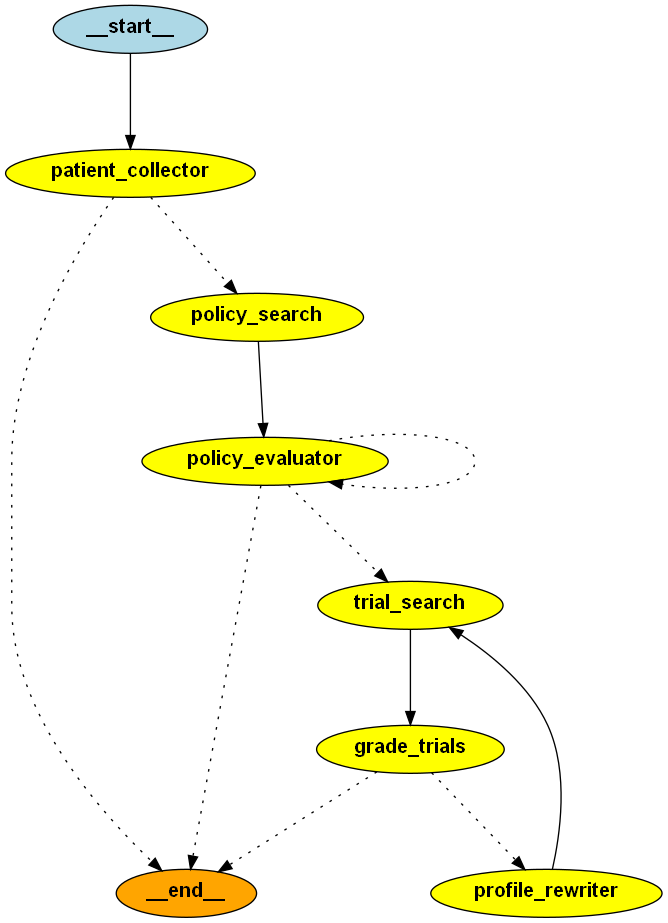

In [113]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.pydantic_v1 import BaseModel, Field
from operator import itemgetter
from typing import Literal
from langgraph.graph import StateGraph, END


model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost

memory = SqliteSaver.from_conn_string(":memory:")

class Patient_ID(BaseModel):
    patient_id: int
    # no_id: bool

def patient_collector_node(state: AgentState):
    patient_data_prompt = """You are a helpful assistance in extrcting patient's medical history.
Based on the following request identify and return the patient's ID number.
"""

    response = model.with_structured_output(Patient_ID).invoke([
        SystemMessage(content=patient_data_prompt),
        HumanMessage(content=state['patient_prompt'])
    ])
    patient_id = response.patient_id
    # print(response)
    print(f"Patient ID: {patient_id}")
    patient_data = get_patient_data(patient_id)
    print(patient_data)
    if patient_data is not None:        
        if patient_data.get('name'):
            del patient_data['patient_id']
            del patient_data['name']
        patient_profile = chain_profile.invoke({'patient_data': patient_data})

    return {
        "last_node": "patient_collector",
        "patient_data": patient_data,
        "patient_profile": patient_profile,
        "patient_id": patient_id,
        "revision_number": state.get("revision_number", 1) + 1,
        'policy_eligible': 'N/A'
        }

def policy_search(state: AgentState) -> List[Document]:    
    # question = f"""
    # Does the following patient profile comply with the institutional policies?\n
    # {patient_profile}
    # """
    docs_retrieved = retriever_policy.get_relevant_documents(patient_profile)    
    return {
        "last_node": "policy_search",
        "policies": docs_retrieved,
        "unchecked_policies": docs_retrieved.copy(),
    }

def policy_evaluator(state: AgentState, policy_doc: Document = None):
    if policy_doc is None:
        policy_doc = state['unchecked_policies'][0]
    
    policy_header = policy_doc.page_content.split('\n', 2)[1]
    print(f'Evaluating Policy:\n {policy_header}')
    
    policy = policy_doc.page_content
    
    policy_qs = policy_rps_chain.invoke({"policy": policy})
    
    # result = policy_repl(policy_qs, state['patient_profile'])
    result = policy_tools(policy_qs, state['patient_profile'])
    # nprint(result['output'])

    class eligibility(BaseModel):
        """ Give the patient's eligibility result."""

        eligibility: str = Field(description="Patient's eligibility for the clinical trial. 'yes' or 'no'")
        reason: str = Field(description="The reason(s) only if the patient is not eligible for clinical trials. Othereise use N/A")

        class Config:
            schema_extra = {
                "example": {
                    "eligibility": 'yes',
                    "reason": "N/A",
                },
                "example 2": {
                    "eligibility": 'no',
                    "reason": "The patient is pregnant at the moment.",
                },                
            }

    llm_with_tools = model.bind_tools([eligibility])
    message = f"""Evaluation of the patient's eligibility:
    {result}\n\n
    Is the patient eligible according to this policy?"""
    response = llm_with_tools.invoke(message)
            
    state["policy_eligible"] = response.tool_calls[0]['args']['eligibility'] == 'yes'
    state["rejection_reason"] = response.tool_calls[0]['args']['reason']
    
    # remove the first element of unchecked_policies
    state['unchecked_policies'].pop(0)
    state["revision_number"] = state.get("revision_number", 1) + 1
    state['checked_policy'] = policy_doc
    state['policy_qs'] = policy_qs
    state['last_node'] = 'policy_evaluator'

    return state

def trial_search(state: AgentState):
    """
    This node searches the trial database to retrieve a list of clinical trials that match the patient's medical history.
    """

    patient_profile = state['patient_profile']

    question = f"""
    Which trials are relevant to the patient with the following medical history?\n
    patient_profile: {patient_profile}
    """        
    docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
    # print(state)
    trial_searches = state.get('trial_searches') or 0
    return {
        'last_node': 'trial_search',
        'trials': docs_retrieved,
        'trial_searches': trial_searches + 1,
        }

def grade_trials(state: AgentState, trials: List[Document] = None):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("----- CHECKING THE TRIALS RELEVANCE TO PATIENT PROFILE ----- ")
    
    if trials is None:
        trials = state['trials']
    patient_profile = state['patient_profile']

    # Score each doc
    relevant_trials = []
    for trial in trials:
        doc_txt = trial.page_content
        trial_diseases = trial.metadata['diseases']
        nctid = trial.metadata['nctid']
        print(f"---GRADER: TRIAL {nctid}: ---") 
        trial_score = retrieval_grader.invoke(
            {
                "patient_profile": patient_profile, 
                "document": doc_txt, 
                "trial_diseases": trial_diseases
            }
        )
            
        relevance_score = trial_score.relevance_score
        trial_score_dic = dict(trial_score)
        trial_score_dic['nctid'] = nctid                    

        if relevance_score.lower() == "yes":   
            # Hullucination check         
            explanation = trial_score.explanation            
            factual_score = hallucination_grader.invoke({"patient_profile": patient_profile, "explanation": explanation})
            factual_score_grade = factual_score.binary_score            
            if factual_score_grade == "no":
                print("--- HALLUCINATION: MODEL'S EXPLANATION IS NOT GROUNDED IN PATIENT PROFILE --> REJECTED---")
                trial_score_dic['relevance_score'] = 'no'
                trial_score_dic['explanation'] = "Agent's Hallucination"

        if relevance_score.lower() == "yes" and factual_score_grade == "yes":
            print(f"---TRIAL RELEVANT---")                        
        else:
            print(f"--- TRIAL NOT RELEVANT---")

        relevant_trials.append(trial_score_dic)
        
    return {
        'last_node': 'grade_trials',
        "relevant_trials": relevant_trials
        }

def profile_rewriter(state: AgentState):
    patient_data = state['patient_data']
    patient_profile_rewriten = profile_rewriter_chain.invoke({"patient_data": patient_data})
    # print in capitals
    print("--- PROFILE REWRITER: PATIENT'S PROFILE REWRITEN ---")
    # state['patient_profile'] = patient_profile_rewriten
    return {
        'last_node': 'profile_rewriter',
        'patient_profile': patient_profile_rewriten
    }
    

# ========= continue functions =========
def should_continue_patient(state: AgentState):
    # end = False
    if state.get("patient_data"):
        # print('patient data found')
        print(state.get("patient_profile", 'No profile generated'))
        return "policy_search"
    else:
        print('Patient data not found in the database')
        return END
        
    if state["revision_number"] > state["max_revisions"]:
        print('max revision reached')
        # print(state.get("patient_data", 1))
        return END        

def should_continue_policy(state: AgentState):
    if state["revision_number"] > state["max_revisions"]:
        print('max revision reached')        
        return END
    more_policies = len(state["unchecked_policies"]) > 0
    if state["policy_eligible"]:
        if more_policies:
            print("-------------- Check the next policy --------------")
            return "policy_evaluator"
        else:
            print("-------------- Patient passed the general trials policies --------------")
            return "trial_search"
    else:
        print("Patient did not pass this policy.\n")
        print(state['checked_policy'].page_content)
        # print("Patient did not pass the general trials policies.\n")        
        print('Rejection Reason: ')
        nprint(state['rejection_reason'])
        print("You can correct the patient's medical profile if required.")        
        return END

def should_continue_trials(state: AgentState):
    relevant_trials = state["relevant_trials"]    
    has_relevant_trial = any(trial['relevance_score'] == 'Yes' for trial in state["relevant_trials"])

    if state["trial_searches"] > state["max_trial_searches"]:
        print('max trial searches reached')
        next = END    
    # elif not state["relevant_trials"]:
    elif has_relevant_trial == False:
        print('----- No relevant trials found --> rewriting the patient profile -----')
        next = "profile_rewriter"        
    else:
        next = END
        print('to end')
    return next


# ==== define graph nodes====
builder = StateGraph(AgentState)
builder.set_entry_point("patient_collector")
builder.add_node("patient_collector", patient_collector_node)
builder.add_node("policy_search", policy_search)
builder.add_node("policy_evaluator", policy_evaluator)
builder.add_node("trial_search", trial_search)
builder.add_node("grade_trials", grade_trials)
builder.add_node("profile_rewriter", profile_rewriter)

# ===== define graph edges====
builder.add_conditional_edges(
    "patient_collector", 
    should_continue_patient, 
    {END: END    
    ,"policy_search": "policy_search"
    }
)

builder.add_conditional_edges(
    "policy_evaluator", 
    should_continue_policy, 
    {
    "trial_search": "trial_search"
    , "policy_evaluator": "policy_evaluator"
    , END: END
    }
)

builder.add_edge("policy_search", "policy_evaluator")
builder.add_edge("trial_search", "grade_trials")
builder.add_edge("profile_rewriter","trial_search")
# builder.set_finish_point("grade_trials")

builder.add_conditional_edges(
    "grade_trials", 
    should_continue_trials, 
    {
    "profile_rewriter": "profile_rewriter"    
    , END: END
    }
)



graph = builder.compile(
    checkpointer=memory
)

from IPython.display import Image

Image(graph.get_graph().draw_png())

Running with no gui and intrupts:

In [27]:
import langchain
langchain.debug = False
sample_patient_id = 2
thread = {"configurable": {"thread_id": "0"}}
events_gen = graph.stream({
    'patient_prompt': f"Is patient {sample_patient_id} eligible for any medical trial?",    
    "max_revisions": 10,
    "revision_number": 1,
    'max_trial_searches':3,
}, thread)
for event in events_gen:
    print(event)
# event = events_gen.__next__()

Patient ID: 2
{'patient_id': 2, 'name': 'Alice Brown', 'age': 70, 'medical_history': 'Anxiety', 'previous_trials': 'NCT08008231', 'trial_status': 'Ongoing', 'trial_completion_date': None}
Patient is a 70-year-old individual with a medical history of anxiety. They have previously participated in the clinical trial NCT08008231, which is currently ongoing. Given their history of anxiety, the patient may be suitable for clinical trials focusing on mental health or anxiety disorders.
{'patient_collector': {'last_node': 'patient_collector', 'patient_id': 2, 'patient_data': {'age': 70, 'medical_history': 'Anxiety', 'previous_trials': 'NCT08008231', 'trial_status': 'Ongoing', 'trial_completion_date': None}, 'patient_profile': 'Patient is a 70-year-old individual with a medical history of anxiety. They have previously participated in the clinical trial NCT08008231, which is currently ongoing. Given their history of anxiety, the patient may be suitable for clinical trials focusing on mental heal

# Application GUI

In [114]:
from helper_gui import trials_gui

memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(
    checkpointer=memory
    , interrupt_after=['patient_collector', 'policy_search', 'trial_search', 'grade_trials', 'profile_rewriter']
    # , interrupt_after=['grade_trials','profile_rewriter']
)

try:
    app.demo.close()
except:
    print('initial run')
app = trials_gui(graph)    
app.demo.launch(server_name="127.0.0.1", server_port=7959)

Closing server running on port: 7959
Running on local URL:  http://127.0.0.1:7959

To create a public link, set `share=True` in `launch()`.


Patient ID: 56
{'patient_id': 56, 'name': 'James Thomas', 'age': 52, 'medical_history': 'Depression', 'previous_trials': None, 'trial_status': None, 'trial_completion_date': None}
Patient is a 52-year-old individual with a history of Depression. There is no record of previous trial participation. Given the patient's medical history of Depression, they may be suitable for clinical trials focusing on new antidepressant medications or therapies for mental health conditions.
Patient ID: 5
{'patient_id': 5, 'name': 'John Davis', 'age': 40, 'medical_history': 'Hypertension', 'previous_trials': 'NCT09100764', 'trial_status': 'Withdrawn', 'trial_completion_date': '2023-10-24'}
Patient X is a 40-year-old individual with a medical history of hypertension. They have previously participated in the clinical trial with the identifier NCT09100764, which was withdrawn before completion on October 24, 2023. Given their history of hypertension, the patient may be eligible for clinical trials related to 

# Possible Further Improvements for Real Application:

To enhance the robustness of the pipeline and effectively manage diverse patient and trial conditions, it is essential to implement advanced methodologies, particularly when handling large databases of patients, trials, and policies.

Recommended Improvements:
1. Graph-Based Retrieval-Augmented Generation (RAG):
- Implement graph-based RAG to focus on the relationships between entities across different databases. For instance, map connections between patients, diseases, drugs, and trials to provide more accurate and relevant information retrieval.

2. Advanced RAG pipeline:
- The output of RAG pipelines can be improved by benefiting from more advanced techniques such as Adaptive RAG, Corrective RAG, and Self-RAG. Such pipelines are more robust againts hallucinations and wrong inferences in LLMs outputs.

4. Advanced Chain of Thought Processing:
- Employ a more sophisticated chain of thought process to cross-match the patient's profile with the detailed information provided in each trial or policy. This approach enhances the decision-making capability of the system by considering multiple factors simultaneously.

1. Fine-Tuning the Large Language Model:
- Fine-tune the large language model using a diverse set of medical trial data to improve the accuracy and relevance of its inferences. This customization ensures the model better understands the nuances and specifics of clinical trial data.

1. Cyclic Graphs for Iterative Evaluation:
- Utilize cyclic graphs to iteratively evaluate the patient's profile against various trials and policies. This iterative approach allows the system to refine its matches through multiple rounds of evaluation, ultimately identifying the best possible trial for the patient.